In [28]:
import sys
sys.path.append("../../../") # Where to find utilssphering
import utilssphering
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import glob

In [29]:
# Read CSV
match_rep_df = pd.read_csv("../../../checkpoints/match_rep_df.csv")
match_rep_df

,Vendor,Batch,Plate_Map_Name,Assay_Plate_Barcode,Modality,Images_per_well,Sites-SubSampled,Binning,Magnification,Number_of_channels,...,Size_MB_std,sphering,value_95_replicating,Percent_Replicating,channel_names,brightfield_z_plane_used,feature_channels_found,Percent_Matching,value_95_matching,cell_count
0,MolDev,Scope1_MolDev_10X,JUMP-MOA_compound_platemap,Plate2_PCO_6ch_4site_10XPA,Confocal,4,NaN,1,10,6,...,0.000144,True,0.191908,60.000000,"Actin, DNA, ER, Golgi, Mito, RNA",NaN,"Actin, DNA, ER, Golgi, Mito, RNA",23.255814,0.288099,2014937
1,MolDev,Scope1_MolDev_10X,JUMP-MOA_compound_platemap,Plate2_PCO_6ch_4site_10XPA,Confocal,4,NaN,1,10,6,...,0.000144,False,0.269727,53.333333,"Actin, DNA, ER, Golgi, Mito, RNA",NaN,"Actin, DNA, ER, Golgi, Mito, RNA",18.604651,0.320855,2014937
2,MolDev,Scope1_MolDev_10X,JUMP-MOA_compound_platemap,Plate3_PCO_6ch_4site_10XPA_Crest,Confocal,4,NaN,1,10,6,...,0.000183,True,0.269617,62.222222,"Actin, DNA, ER, Golgi, Mito, RNA",NaN,"Actin, DNA, ER, Golgi, Mito, RNA",18.604651,0.398249,2413350
3,MolDev,Scope1_MolDev_10X,JUMP-MOA_compound_platemap,Plate3_PCO_6ch_4site_10XPA_Crest,Confocal,4,NaN,1,10,6,...,0.000183,False,0.329074,45.555556,"Actin, DNA, ER, Golgi, Mito, RNA",NaN,"Actin, DNA, ER, Golgi, Mito, RNA",18.604651,0.389170,2413350
4,MolDev,Scope1_MolDev_10X_4siteZ,JUMP-MOA_compound_platemap,Plate3_PCO_6ch_4site_10XPA_Crestz,Confocal,4,NaN,1,10,6,...,0.000142,True,0.205121,66.666667,"Actin, DNA, ER, Golgi, Mito, RNA",NaN,"Actin, DNA, ER, Golgi, Mito, RNA",23.255814,0.363114,2381443
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
357,Yokogawa_US,4siteSubSample_Scope1_Yokogawa_US_20X_6Ch_BRO0...,JUMP-MOA_compound_platemap,BRO0117059_20X,Confocal,9,4.0,1,20,6,...,0.000583,False,0.628379,20.000000,"AGP, BrightField, DNA, ER, Mito, RNA",Z08,"AGP, BrightField, DNA, ER, Mito, RNA",6.976744,0.772160,489099
358,Yokogawa_US,4siteSubSample_Scope1_Yokogawa_US_20X_6Ch_BRO0...,JUMP-MOA_compound_platemap,BRO01177034_20x,Confocal,9,4.0,1,20,6,...,0.000014,True,0.139090,56.666667,"AGP, BrightField, DNA, ER, Mito, RNA",Z17,"AGP, BrightField, DNA, ER, Mito, RNA",18.604651,0.193171,452567
359,Yokogawa_US,4siteSubSample_Scope1_Yokogawa_US_20X_6Ch_BRO0...,JUMP-MOA_compound_platemap,BRO01177034_20x,Confocal,9,4.0,1,20,6,...,0.000014,False,0.666818,21.111111,"AGP, BrightField, DNA, ER, Mito, RNA",Z17,"AGP, BrightField, DNA, ER, Mito, RNA",9.302326,0.790813,452567
360,Yokogawa_US,4siteSubSample_Scope1_Yokogawa_US_40X_BRO0117059,JUMP-MOA_compound_platemap,BRO0117059_40x,Confocal,9,4.0,1,40,6,...,0.080201,True,0.193787,53.333333,"AGP, BrightField, DNA, ER, Mito, RNA",Z08,"AGP, BrightField, DNA, ER, Mito, RNA",20.930233,0.234702,116595


In [30]:
def format_column_names(column_name):
    """
    For a given string, hyphens and underscores are replaced with spaces and 
    first letters are capitalised.
    """
    return column_name.title().replace("-", " ").replace("_", " ")

def aggregate_duplicates(df):
    """
    Group data on setting columns, calculate the mean for grouped rows
    (which are therefore duplicates).

    The returned dataframe will not contain Assay_Plate_Barcode, since 
    the unique barcodes cannot be reconciled into an aggregated mean, 
    so are therefore dropped.
    """
    # Columns to not be used for grouping
    non_group_cols = [
        "Assay_Plate_Barcode",
        "Batch",
        "Vendor",
        "value_95_replicating",
        "Percent_Replicating",
        "Size_MB",
        "Size_MB_std",
        "Percent_Matching",
        "value_95_matching",
        "cell_count",
        "Sites-SubSampled",
        "BF_Zplanes", # Ignore since only one BF zplane is used
        "brightfield_z_plane_used",
        # Remove channel names due to some profiles having "AGP" features 
        # and others having "WGPhalloidin" instead
        "feature_channels_found",
        "channel_names"
    ]
    # Find the columns that are not in non_group_cols
    diff = list(set(df.columns) - set(non_group_cols))
    # Group df by setting columns, find the mean, then reset the index
    df = df.groupby(diff, dropna=False, as_index=False).mean()
    return df

def make_leaderboard(df, columns, average_duplicates=True):
    """
    Process match_rep_df into a nice leaderboard
    """
    if average_duplicates:
        df = aggregate_duplicates(df)

    # Create an aggregation score for replicating/matching and normalize to the max value
    df["Percent_Score"] = df[["Percent_Replicating", "Percent_Matching"]].mean(axis=1)
    df["Percent_Score"] = (df["Percent_Score"] / df["Percent_Score"].max()) * 100
    df = df.round({"Percent_Score": 1})

    # Sort based on the Percent_Score and then add Place (ie 1st, 2nd, 3rd etc.)
    df = df.sort_values("Percent_Score", ascending=False)[columns]
    df["Place"] = df.reset_index(drop=True).index+1
    
    # Move place column to first position
    df.insert(0, "Place", df.pop("Place"))

    # Format column_names
    df.rename(columns=format_column_names, inplace=True)
    df.rename(columns={"Z Plane": "Z Planes"}, inplace=True)
    df.rename(columns={"Aperture": "NA"}, inplace=True)
    df.rename(columns={"Dry Immersion": "Immersion"}, inplace=True)
    return df

# Microscopes used by each vendor

- Yokogawa US
  - Yokogawa CV8000
- Yokogawa Japan
  - CQ1
- Perkin Elmer
  - Opera Phenix Plus
- Molecular Devices
  - ImageXpress Micro Confocal (IXM-Confocal)
- Nikon
  - Eclipse Ti2 inverted microscope

The lowest top %score (which is mean %rep %match) was Nikon. Highest top score was Molecular Devices

The %score (max-min) ranges are as follows:

PE: 40.9-39.1
Nikon: 38.8-31.3
Yokogawa_Japan: 43.9-33.7
Yokogawa_US: 45-36.5
MolDev: 45.5-38.2

In [33]:
moldev_cols = [
    'Modality',
    'Binning',
    'Magnification',
    'aperture',
    'Number_of_channels',
    'z_plane',
    'spinning-disc',
    'sites',
    "Percent_Score",
]

df = match_rep_df[
    (match_rep_df["Vendor"].str.contains("MolDev")) &
    (~match_rep_df["Batch"].str.contains("siteSub")) &
    (match_rep_df["sphering"] == True)
].copy()

df = make_leaderboard(df, moldev_cols)

assert not df.equals(df.drop("Place", axis=1).drop_duplicates()), "DataFrame contains duplicates"

df.to_csv("(1)-moldev_leaderboard.csv", index=False)

df

,Place,Modality,Binning,Magnification,NA,Number Of Channels,Z Planes,Spinning Disc,Sites,Percent Score
4,1,Confocal,1,20,0.75,6,1,no,9,100.0
2,2,Confocal,1,10,0.45,6,3,yes,4,98.8
0,3,Confocal,1,10,0.45,6,1,no,4,91.5
1,4,Confocal,1,10,0.45,6,1,yes,4,88.8
5,5,Confocal,1,20,0.75,6,1,yes,9,87.7
3,6,Confocal,1,20,0.75,6,3,yes,4,83.9


In [34]:
yokogawa_us_cols = [
    'Modality',
    'Binning',
    'Magnification',
    'aperture',
    'Number_of_channels',
    "simultaneous-excitation",
    'z_plane',
    "dry-immersion",
    'sites',
    "Percent_Score",

]

df = match_rep_df[
    (match_rep_df["Vendor"].str.contains("Yokogawa_US")) &
    (~match_rep_df["Batch"].str.contains("siteSub")) &
    (match_rep_df["sphering"] == True)
].copy()

df["simultaneous-excitation"] = df["simultaneous-excitation"].astype("Int64")

df = make_leaderboard(df, yokogawa_us_cols, average_duplicates=True)

assert not df.equals(df.drop("Place", axis=1).drop_duplicates()), "DataFrame contains duplicates"

df.to_csv("(2)-yokogawa_us_leaderboard.csv", index=False)

df

,Place,Modality,Binning,Magnification,NA,Number Of Channels,Simultaneous Excitation,Z Planes,Immersion,Sites,Percent Score
2,1,Confocal,1,20,1.0,5,2,12,water,9,100.0
1,2,Confocal,1,20,1.0,5,2,1,water,9,91.3
3,3,Confocal,1,20,1.0,6,4,12,water,9,90.0
0,4,Confocal,1,10,0.4,6,2,12,dry,4,88.9
4,5,Confocal,1,40,1.0,6,4,12,water,9,81.2


In [36]:
yokogawa_japan_cols = [
    'Modality',
    'Binning',
    'Magnification',
    'aperture',
    'Number_of_channels',
    'z_plane',
    "dry-immersion",
    'sites',
    "Percent_Score",
]

df = match_rep_df[
    (match_rep_df["Vendor"].str.contains("Yokogawa_Japan")) &
    (~match_rep_df["Batch"].str.contains("siteSub")) &
    (match_rep_df["sphering"] == True)
].copy()

df = make_leaderboard(df, yokogawa_japan_cols)

assert not df.equals(df.drop("Place", axis=1).drop_duplicates()), "DataFrame contains duplicates"

df.to_csv("(3)-yokogawa_japan_leaderboard.csv", index=False)

df

,Place,Modality,Binning,Magnification,NA,Number Of Channels,Z Planes,Immersion,Sites,Percent Score
0,1,Confocal,1,20,0.75,5,10,dry,9,100.0
1,2,Confocal,1,40,0.95,5,12,dry,2,77.0


In [37]:
nikon_cols = [
    'Modality',
    'Binning',
    'Magnification',
    'aperture',
    'Number_of_channels',
    'z_plane',
    "dry-immersion",
    'sites',
    "Percent_Score",
]

df = match_rep_df[
    (match_rep_df["Vendor"].str.contains("Nikon")) &
    (~match_rep_df["Batch"].str.contains("siteSub")) &
    (match_rep_df["sphering"] == True)
].copy()

df = make_leaderboard(df, nikon_cols)

assert not df.equals(df.drop("Place", axis=1).drop_duplicates()), "DataFrame contains duplicates"

df.to_csv("(4)-nikon_leaderboard.csv", index=False)

df

,Place,Modality,Binning,Magnification,NA,Number Of Channels,Z Planes,Immersion,Sites,Percent Score
1,1,Widefield,1,20,0.75,4,1,dry,9,100.0
0,2,Widefield,1,10,0.45,4,1,dry,1,80.7


In [39]:
pe_cols = [
    'Modality',
    'Binning',
    'Magnification',
    'aperture',
    'Number_of_channels',
    'z_plane',
    "dry-immersion",
    'sites',
    "Percent_Score",
]

df = match_rep_df[
    (match_rep_df["Vendor"].str.contains("PE")) &
    (~match_rep_df["Batch"].str.contains("siteSub")) &
    (match_rep_df["sphering"] == True)
].copy()

df = make_leaderboard(df, pe_cols)

assert not df.equals(df.drop("Place", axis=1).drop_duplicates()), "DataFrame contains duplicates"

df.to_csv("(5)-pe_leaderboard.csv", index=False)

df

,Place,Modality,Binning,Magnification,NA,Number Of Channels,Z Planes,Immersion,Sites,Percent Score
1,1,Confocal,2,20,1.0,5,1,water,3,100.0
4,2,Widefield,1,20,1.0,5,1,water,3,99.6
3,3,Confocal,2,20,1.0,5,3,water,3,98.8
5,4,Widefield,2,20,1.0,5,1,water,3,98.6
7,5,Widefield,2,20,1.0,5,3,water,3,98.2
6,6,Widefield,1,20,1.0,5,3,water,3,97.5
2,7,Confocal,1,20,1.0,5,3,water,3,97.2
0,8,Confocal,1,20,1.0,5,1,water,3,95.5


In [244]:
# Create a non-parameter test using microscope place for the distribution
# Compare between widefield and confocal
moldev_cols = [
    'Modality',
    'Binning',
    'Magnification',
    'aperture',
    'Number_of_channels',
    'z_plane',
    'spinning-disc',
    'sites'
]

moldev_df = match_rep_df[
    (match_rep_df["Vendor"].str.contains("MolDev")) &
    (~match_rep_df["Batch"].str.contains("siteSub")) &
    (match_rep_df["sphering"] == True)
].copy()

moldev_df = make_leaderboard(moldev_df, moldev_cols, average_duplicates=False)


yokogawa_us_cols = [
    'Modality',
    'Binning',
    'Magnification',
    'aperture',
    'Number_of_channels',
    "simultaneous-excitation",
    'z_plane',
    "dry-immersion",
    'sites',

]

yokogawa_us_df = match_rep_df[
    (match_rep_df["Vendor"].str.contains("Yokogawa_US")) &
    (~match_rep_df["Batch"].str.contains("siteSub")) &
    (match_rep_df["sphering"] == True)
].copy()

df["simultaneous-excitation"] = df["simultaneous-excitation"].astype("Int64")

yokogawa_us_df = make_leaderboard(yokogawa_us_df, yokogawa_us_cols, average_duplicates=False)

yokogawa_japan_cols = [
    'Modality',
    'Binning',
    'Magnification',
    'aperture',
    'Number_of_channels',
    'z_plane',
    "dry-immersion",
    'sites'
]

yokogawa_japan_df = match_rep_df[
    (match_rep_df["Vendor"].str.contains("Yokogawa_Japan")) &
    (~match_rep_df["Batch"].str.contains("siteSub")) &
    (match_rep_df["sphering"] == True)
].copy()

yokogawa_japan_df = make_leaderboard(yokogawa_japan_df, yokogawa_japan_cols, average_duplicates=False)


nikon_cols = [
    'Modality',
    'Binning',
    'Magnification',
    'aperture',
    'Number_of_channels',
    'z_plane',
    "dry-immersion",
    'sites'
]

nikon_df = match_rep_df[
    (match_rep_df["Vendor"].str.contains("Nikon")) &
    (~match_rep_df["Batch"].str.contains("siteSub")) &
    (match_rep_df["sphering"] == True)
].copy()

nikon_df = make_leaderboard(nikon_df, nikon_cols, average_duplicates=False)

pe_cols = [
    'Modality',
    'Binning',
    'Magnification',
    'aperture',
    'Number_of_channels',
    'z_plane',
    "dry-immersion",
    'sites'
]

pe_df = match_rep_df[
    (match_rep_df["Vendor"].str.contains("PE")) &
    (~match_rep_df["Batch"].str.contains("siteSub")) &
    (match_rep_df["sphering"] == True)
].copy()

pe_df = make_leaderboard(pe_df, pe_cols, average_duplicates=False)


KeyError: 'simultaneous-excitation'

In [83]:
all_leaderboards = pd.concat([moldev_df, yokogawa_us_df, yokogawa_japan_df, nikon_df, pe_df])

all_leaderboards.reset_index()


,index,Place,Modality,Binning,Magnification,NA,Number Of Channels,Z Planes,Spinning Disc,Sites,Simultaneous Excitation,Immersion
0,8,1,Confocal,1,20,0.75,6,1,no,9,NaN,NaN
1,4,2,Confocal,1,10,0.45,6,3,yes,4,NaN,NaN
2,0,3,Confocal,1,10,0.45,6,1,no,4,NaN,NaN
3,2,4,Confocal,1,10,0.45,6,1,yes,4,NaN,NaN
4,10,5,Confocal,1,20,0.75,6,1,yes,9,NaN,NaN
5,6,6,Confocal,1,20,0.75,6,3,yes,4,NaN,NaN
6,100,1,Confocal,1,20,1.00,5,12,NaN,9,2.0,water
7,98,2,Confocal,1,20,1.00,5,1,NaN,9,2.0,water
8,102,3,Confocal,1,20,1.00,6,12,NaN,9,4.0,water
9,94,4,Confocal,1,10,0.40,6,12,NaN,4,2.0,dry


In [164]:
t = [moldev_df, yokogawa_us_df, yokogawa_japan_df, nikon_df, pe_df]
t[4]

,Place,Modality,Binning,Magnification,NA,Number Of Channels,Z Planes,Immersion,Sites
76,1,Widefield,2,20,1.0,5,1,water,3
48,2,Widefield,1,20,1.0,5,1,water,3
70,3,Confocal,2,20,1.0,5,3,water,3
44,4,Widefield,1,20,1.0,5,1,water,3
62,5,Confocal,2,20,1.0,5,1,water,3
60,6,Confocal,2,20,1.0,5,1,water,3
86,7,Widefield,2,20,1.0,5,3,water,3
80,8,Widefield,2,20,1.0,5,1,water,3
68,9,Confocal,2,20,1.0,5,3,water,3
58,10,Confocal,2,20,1.0,5,1,water,3


In [35]:
scipy.stats.mannwhitneyu(
    x = all_leaderboards[all_leaderboards["Modality"] == "Confocal"]["Place"].values,
    y = all_leaderboards[all_leaderboards["Modality"] == "Widefield"]["Place"].values
)

MannwhitneyuResult(statistic=319.5, pvalue=0.5224850606376024)

In [36]:
scipy.stats.kruskal(
    all_leaderboards[all_leaderboards["Modality"] == "Confocal"]["Place"].values,
    all_leaderboards[all_leaderboards["Modality"] == "Widefield"]["Place"].values
    )

KruskalResult(statistic=0.42026695430460737, pvalue=0.5168038693177608)

In [37]:
# Mann Whitney for PE confocal/widefield only

scipy.stats.mannwhitneyu(
    x = pe_df[pe_df["Modality"] == "Confocal"]["Place"].values,
    y = pe_df[pe_df["Modality"] == "Widefield"]["Place"].values
)

MannwhitneyuResult(statistic=141.0, pvalue=0.6375611304257702)

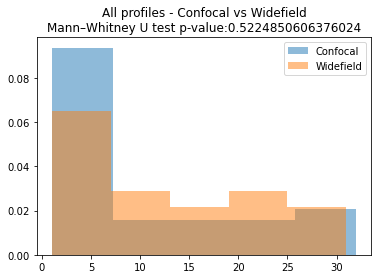

In [166]:
fig, ax = plt.subplots()
x1 = all_leaderboards[all_leaderboards["Modality"] == "Confocal"]["Place"].values
x2 = all_leaderboards[all_leaderboards["Modality"] == "Widefield"]["Place"].values

ax.hist(x1, alpha=0.5, bins=5, density=True, label="Confocal")
ax.hist(x2, alpha=0.5, bins=5, density=True,  label="Widefield")
ax.set_title(f"""All profiles - Confocal vs Widefield
Mann–Whitney U test p-value:{scipy.stats.mannwhitneyu(
    x = x1,
    y = x2
)[1]}""")
ax.legend()
fig.set_facecolor("white")


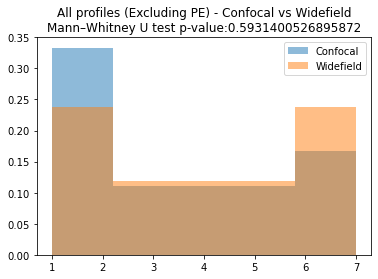

In [178]:
fig, ax = plt.subplots()
no_pe = pd.concat([moldev_df, yokogawa_us_df, yokogawa_japan_df, nikon_df])
no_pe
x1 = no_pe[no_pe["Modality"] == "Confocal"]["Place"].values
x2 = no_pe[no_pe["Modality"] == "Widefield"]["Place"].values

ax.hist(x1, alpha=0.5, bins=5, density=True, label="Confocal")
ax.hist(x2, alpha=0.5, bins=5, density=True,  label="Widefield")
ax.set_title(f"""All profiles (Excluding PE) - Confocal vs Widefield
Mann–Whitney U test p-value:{scipy.stats.mannwhitneyu(
    x = x1,
    y = x2
)[1]}""")
ax.legend()
fig.set_facecolor("white")


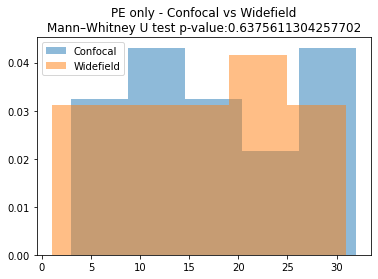

In [167]:
fig, ax = plt.subplots()

x1 = pe_df[pe_df["Modality"] == "Confocal"]["Place"].values
x2 = pe_df[pe_df["Modality"] == "Widefield"]["Place"].values
ax.hist(x1, alpha=0.5, bins=5, density=True,  label="Confocal")
ax.hist(x2, alpha=0.5, bins=5, density=True,  label="Widefield")
ax.legend()
ax.set_title(f"""PE only - Confocal vs Widefield
Mann–Whitney U test p-value:{scipy.stats.mannwhitneyu(
    x = pe_df[pe_df["Modality"] == "Confocal"]["Place"].values,
    y = pe_df[pe_df["Modality"] == "Widefield"]["Place"].values
)[1]}""")
fig.set_facecolor("white")

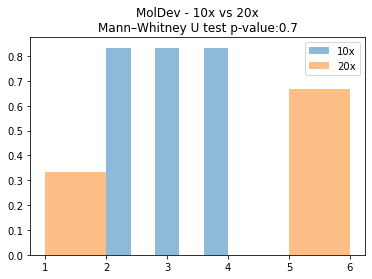

In [168]:
fig, ax = plt.subplots()
x1 = moldev_df[moldev_df["Magnification"] == 10]["Place"].values
x2 = moldev_df[moldev_df["Magnification"] == 20]["Place"].values

ax.hist(x1, alpha=0.5, bins=5, density=True,  label="10x")
ax.hist(x2, alpha=0.5, bins=5, density=True,  label="20x")
ax.set_title(f"""MolDev - 10x vs 20x
Mann–Whitney U test p-value:{scipy.stats.mannwhitneyu(
    x = x1,
    y = x2
)[1]}""")
ax.legend()
fig.set_facecolor("white")

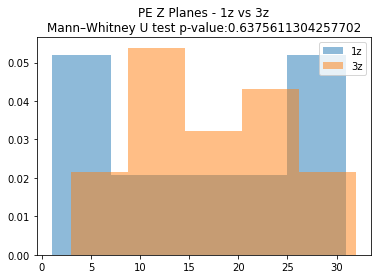

In [169]:
fig, ax = plt.subplots()
x1 = pe_df[pe_df["Z Planes"] == 1]["Place"].values
x2 = pe_df[pe_df["Z Planes"] == 3]["Place"].values

ax.hist(x1, alpha=0.5, bins=5, density=True,  label="1z")
ax.hist(x2, alpha=0.5, bins=5, density=True,  label="3z")
ax.set_title(f"""PE Z Planes - 1z vs 3z
Mann–Whitney U test p-value:{scipy.stats.mannwhitneyu(
    x = x1,
    y = x2
)[1]}""")
ax.legend()
fig.set_facecolor("white")

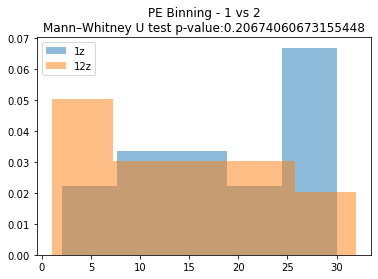

In [170]:
fig, ax = plt.subplots()
x1 = pe_df[pe_df["Binning"] == 1]["Place"].values
x2 = pe_df[pe_df["Binning"] == 2]["Place"].values

ax.hist(x1, alpha=0.5, bins=5, density=True,  label="1z")
ax.hist(x2, alpha=0.5, bins=5, density=True,  label="12z")
ax.set_title(f"""PE Binning - 1 vs 2
Mann–Whitney U test p-value:{scipy.stats.mannwhitneyu(
    x = x1,
    y = x2
)[1]}""")
ax.legend()
fig.set_facecolor("white")

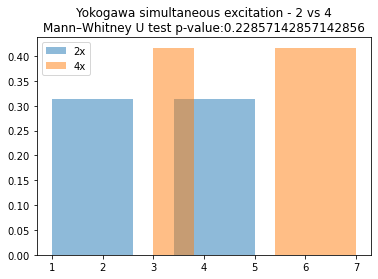

In [171]:
yokogawa_us_df

fig, ax = plt.subplots()
x1 = yokogawa_us_df[yokogawa_us_df["Simultaneous Excitation"] == 2]["Place"].values
x2 = yokogawa_us_df[yokogawa_us_df["Simultaneous Excitation"] == 4]["Place"].values

ax.hist(x1, alpha=0.5, bins=5, density=True,  label="2x")
ax.hist(x2, alpha=0.5, bins=5, density=True,  label="4x")
ax.set_title(f"""Yokogawa simultaneous excitation - 2 vs 4
Mann–Whitney U test p-value:{scipy.stats.mannwhitneyu(
    x = x1,
    y = x2
)[1]}""")
ax.legend()
fig.set_facecolor("white")

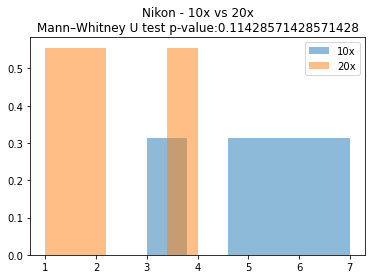

In [172]:
nikon_df

fig, ax = plt.subplots()
x1 = nikon_df[nikon_df["Magnification"] == 10]["Place"].values
x2 = nikon_df[nikon_df["Magnification"] == 20]["Place"].values

ax.hist(x1, alpha=0.5, bins=5, density=True,  label="10x")
ax.hist(x2, alpha=0.5, bins=5, density=True,  label="20x")
ax.set_title(f"""Nikon - 10x vs 20x
Mann–Whitney U test p-value:{scipy.stats.mannwhitneyu(
    x = x1,
    y = x2
)[1]}""")
ax.legend()
fig.set_facecolor("white")

In [193]:
match_rep_df[match_rep_df["Assay_Plate_Barcode"].str.contains("BRO0117014")]

,Vendor,Batch,Plate_Map_Name,Assay_Plate_Barcode,Modality,Images_per_well,Sites-SubSampled,Binning,Magnification,Number_of_channels,...,Size_MB_std,sphering,value_95_replicating,Percent_Replicating,channel_names,brightfield_z_plane_used,feature_channels_found,Percent_Matching,value_95_matching,cell_count
94,Yokogawa_US,Scope1_Yokogawa_US_10X,JUMP-MOA_compound_platemap,BRO0117014_10x,Confocal,4,NaN,1,10,6,...,0.124906,True,0.218493,56.666667,"AGP, BrightField, DNA, ER, Mito, RNA",Z06,"AGP, BrightField, DNA, ER, Mito, RNA",23.255814,0.356314,2047342
95,Yokogawa_US,Scope1_Yokogawa_US_10X,JUMP-MOA_compound_platemap,BRO0117014_10x,Confocal,4,NaN,1,10,6,...,0.124906,False,0.287125,47.777778,"AGP, BrightField, DNA, ER, Mito, RNA",Z06,"AGP, BrightField, DNA, ER, Mito, RNA",18.604651,0.353686,2047342
194,Yokogawa_US,1siteSubSample_Scope1_Yokogawa_US_10X,JUMP-MOA_compound_platemap,BRO0117014_10x,Confocal,4,1.0,1,10,6,...,0.124906,True,0.165562,54.444444,"AGP, BrightField, DNA, ER, Mito, RNA",Z06,"AGP, BrightField, DNA, ER, Mito, RNA",18.604651,0.210178,518568
195,Yokogawa_US,1siteSubSample_Scope1_Yokogawa_US_10X,JUMP-MOA_compound_platemap,BRO0117014_10x,Confocal,4,1.0,1,10,6,...,0.124906,False,0.288096,38.888889,"AGP, BrightField, DNA, ER, Mito, RNA",Z06,"AGP, BrightField, DNA, ER, Mito, RNA",13.953488,0.282212,518568
290,Yokogawa_US,2siteSubSample_Scope1_Yokogawa_US_10X,JUMP-MOA_compound_platemap,BRO0117014_10x,Confocal,4,2.0,1,10,6,...,0.124906,True,0.170352,57.777778,"AGP, BrightField, DNA, ER, Mito, RNA",Z06,"AGP, BrightField, DNA, ER, Mito, RNA",23.255814,0.241135,1032116
291,Yokogawa_US,2siteSubSample_Scope1_Yokogawa_US_10X,JUMP-MOA_compound_platemap,BRO0117014_10x,Confocal,4,2.0,1,10,6,...,0.124906,False,0.330511,37.777778,"AGP, BrightField, DNA, ER, Mito, RNA",Z06,"AGP, BrightField, DNA, ER, Mito, RNA",20.930233,0.339772,1032116
324,Yokogawa_US,3siteSubSample_Scope1_Yokogawa_US_10X,JUMP-MOA_compound_platemap,BRO0117014_10x,Confocal,4,3.0,1,10,6,...,0.124906,True,0.184155,60.000000,"AGP, BrightField, DNA, ER, Mito, RNA",Z06,"AGP, BrightField, DNA, ER, Mito, RNA",23.255814,0.286397,1516909
325,Yokogawa_US,3siteSubSample_Scope1_Yokogawa_US_10X,JUMP-MOA_compound_platemap,BRO0117014_10x,Confocal,4,3.0,1,10,6,...,0.124906,False,0.311965,40.000000,"AGP, BrightField, DNA, ER, Mito, RNA",Z06,"AGP, BrightField, DNA, ER, Mito, RNA",18.604651,0.310764,1516909
